<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [dataset nettoyé](https://drive.google.com/file/d/1-EuzI1ibLAG_1brg_v3MKcDtEgKDFIdl/view?usp=drive_link) dans Google Drive
- Modifier le chemin du fichier dans le code


---

## **Prédiction de la première variable cible: Emission de carbone (TotalGHGEmissions)**

---


## **Sommaire:**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Feature engineering**

### **III. Définitions des variables globales**

### **IV. Prédiction de la variable TotalGHGEmissions**

- **A. LinearRegression**

- **B. RandomForestRegressor**

- **C. GradientBoostingRegressor**

- **D. SVR**

- **E. ElasticNet**

- **F. Choix de l'algorithme**

### **V. Estimer l'effet de la variable ENERGYSTARScore**


# **I. Installation et mise en place de l'environnement de travail**

In [299]:
# installation des librairies
!pip install shap

In [300]:
# importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import shap

import datetime

from google.colab import drive

In [301]:
# informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Run date      : 2024-06-06T17:13:12.806621


In [302]:
# configurations de l'affichages des données
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [303]:
# connexion au drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [304]:
# vérification de l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.pq')
print (df.shape)
df.head(2)

(1476, 15)


,OSEBuildingID,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NbBuildingUsages,BuildingAge,NbYearENERGYSTARCertified,RatioSteamUse,RatioElectricity
0,1,DOWNTOWN,1.0,12,88434,0,Hotel,60.0,7226362.5,249.98,1,89,0,0.28,0.55
1,2,DOWNTOWN,1.0,11,103566,15064,Hotel,61.0,8387933.0,295.86,3,20,0,0.00,0.39


In [305]:
# vérification des données
df.isna().sum(axis=0)

OSEBuildingID                0
Neighborhood                 0
NumberofBuildings            0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFAParking           0
LargestPropertyUseType       0
ENERGYSTARScore              0
SiteEnergyUse(kBtu)          0
TotalGHGEmissions            0
NbBuildingUsages             0
BuildingAge                  0
NbYearENERGYSTARCertified    0
RatioSteamUse                0
RatioElectricity             0
dtype: int64

# **II. Feature engineering**

**Suppression des modalités représentant moins de 5% du dataset**

In [306]:
# Obtenir le nombre d'occurrences de chaque modalité: Neighborhood
modalities_counts = df['Neighborhood'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
Neighborhood
DOWNTOWN                 338
GREATER DUWAMISH         319
LAKE UNION               139
MAGNOLIA / QUEEN ANNE    137
EAST                     110
NORTHEAST                 99
NORTHWEST                 74
BALLARD                   62
NORTH                     57
CENTRAL                   42
DELRIDGE                  38
SOUTHWEST                 31
SOUTHEAST                 30
Name: count, dtype: int64
Neighborhood
DOWNTOWN                 0.228997
GREATER DUWAMISH         0.216125
LAKE UNION               0.094173
MAGNOLIA / QUEEN ANNE    0.092818
EAST                     0.074526
NORTHEAST                0.067073
NORTHWEST                0.050136
BALLARD                  0.042005
NORTH                    0.038618
CENTRAL                  0.028455
DELRIDGE                 0.025745
SOUTHWEST                0.021003
SOUTHEAST                0.020325
Name: count, dtype: float64


In [307]:
# Seuil de 5%
threshold = 0.05 * df.shape[0]

# Transformer en 'OTHER' pour les valeurs représentant moins de 5%
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x if modalities_counts[x] > threshold else 'OTHER')

In [308]:
# Obtenir le nombre d'occurrences de chaque modalité: LargestPropertyUseType
modalities_counts = df['LargestPropertyUseType'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
LargestPropertyUseType
Office                                                  484
Non-Refrigerated Warehouse                              197
Retail Store                                             91
Other                                                    88
Hotel                                                    76
Worship Facility                                         69
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              38
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    28
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/University                 

In [309]:
# Transformer en 'Other' pour les valeurs représentant moins de 5%
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(lambda x: x if modalities_counts[x] > threshold else 'Other')

**Suppression des variables peu pertinentes pour notre modèle**

In [310]:
#pas nécessaire pour l'entrainement des modèles
df.drop(columns=['OSEBuildingID'], inplace=True)

#reponsable de data leaking
df.drop(columns=['SiteEnergyUse(kBtu)'], inplace=True)

# **III. Définitions des variables globales**

In [311]:
TARGET = 'TotalGHGEmissions'
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'PropertyGFAParking']

CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'SiteEnergyUse(kBtu)']
print(CAT_FEATURES)

['Neighborhood', 'LargestPropertyUseType']


In [312]:
df1 = df.copy()

# **IV. Entrainement des modèles**

##**A. LinearRegression**

In [313]:
# séparation des variables explicatives de la variable à prédire
df1 = df.copy()
y = df1.pop(TARGET)
X = df1

In [314]:
# features engineering
y = np.log(y + 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

In [315]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

In [316]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__fit_intercept' : [False, True]
    }

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2') #1476*0.80/5 = 236 données par pli pour cv=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}') #moyenne des scores sur la validation croisée
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_LR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_LR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_LR.score(X_test, y_test)-best_model_LR.score(X_train, y_train)).round(3)}')
mean_time_LR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__fit_intercept': True}
Moyenne des scores: 0.736
----------------
Score sur le train : 0.748
Score sur le test : 0.774
diff = 0.026


In [317]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.096213,0.029307,0.012765,0.005473,False,{'regressor__fit_intercept': False},0.67823,0.759245,0.73076,0.769897,0.739698,0.735566,0.031834,2
1,0.105657,0.026977,0.011801,0.004585,True,{'regressor__fit_intercept': True},0.67823,0.759245,0.73076,0.770035,0.740213,0.735697,0.031877,1


##**B. RandomForestRegressor**

In [237]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
  ])

In [238]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)
# limitation de la complexité pour éviter l'overfitting

param_grid = {
    'regressor__max_depth'     : [3, 4, 5],
    'regressor__criterion'     : ['squared_error', 'absolute_error'],
    'regressor__min_samples_split' : [2, 5, 7, 9]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_RFR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_RFR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_RFR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_RFR.score(X_test, y_test)-best_model_RFR.score(X_train, y_train)).round(3)}')
mean_time_RFR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres: {'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__min_samples_split': 7}
Moyenne des scores: 0.722
----------------
Score sur le train : 0.779
Score sur le test : 0.747
diff = -0.032


In [239]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__criterion,param_regressor__max_depth,param_regressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.436422,0.017480,0.017796,0.001929,squared_error,3,2,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__min_samples_split': 2}",0.598180,0.639580,0.698699,0.687315,0.675667,0.659888,0.036682,19
1,0.502508,0.070604,0.019129,0.001963,squared_error,3,5,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__min_samples_split': 5}",0.599796,0.635592,0.702772,0.682874,0.684769,0.661161,0.037894,17
2,1.130012,0.438836,0.064384,0.021580,squared_error,3,7,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__min_samples_split': 7}",0.599850,0.643688,0.691766,0.678944,0.676381,0.658126,0.033175,24
3,1.658579,0.357438,0.063418,0.046176,squared_error,3,9,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__min_samples_split': 9}",0.598946,0.640077,0.696526,0.691015,0.678472,0.661007,0.036761,18
4,0.884696,0.098709,0.032881,0.009633,squared_error,4,2,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 4, 'regressor__min_samples_split': 2}",0.637062,0.670456,0.735969,0.720600,0.727365,0.698291,0.038175,11
5,0.944422,0.129703,0.036976,0.012105,squared_error,4,5,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 4, 'regressor__min_samples_split': 5}",0.639880,0.672895,0.729726,0.724531,0.726134,0.698633,0.036078,10
6,0.949905,0.160823,0.030946,0.017846,squared_error,4,7,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 4, 'regressor__min_samples_split': 7}",0.634833,0.669079,0.732084,0.723270,0.726221,0.697097,0.038520,15
7,0.819539,0.141448,0.030137,0.004989,squared_error,4,9,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 4, 'regressor__min_samples_split': 9}",0.636257,0.672699,0.732013,0.724729,0.724830,0.698106,0.037533,13
8,1.895174,0.150412,0.056283,0.024526,squared_error,5,2,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 5, 'regressor__min_samples_split': 2}",0.655247,0.689072,0.758477,0.739040,0.753233,0.719014,0.040230,4
9,1.633238,0.319366,0.057813,0.021428,squared_error,5,5,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 5, 'regressor__min_samples_split': 5}",0.653991,0.681414,0.756625,0.742444,0.748871,0.716669,0.041157,7


##**C. GradientBoostingRegressor**

In [240]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
  ])

In [241]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)
# limitation des paramètres pour éviter l'overfitting

param_grid = {
    'regressor__learning_rate'      : [0.10, 0.001, 0.05, 0.20],
    'regressor__max_depth'          : [1],
    'regressor__subsample'          : [0.8, 0.9],
    'regressor__max_features'       : ['sqrt', 'log2'],
    'regressor__loss'               : ['squared_error', 'absolute_error']
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_GBR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_GBR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_GBR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_GBR.score(X_test, y_test)-best_model_GBR.score(X_train, y_train)).round(3)}')
mean_time_GBR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Meilleurs hyperparamètres: {'regressor__learning_rate': 0.2, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.8}
Moyenne des scores: 0.727
----------------
Score sur le train : 0.761
Score sur le test : 0.734
diff = -0.026


In [242]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__loss,param_regressor__max_depth,param_regressor__max_features,param_regressor__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.313746,0.041727,0.019496,0.008049,0.1,squared_error,1,sqrt,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.8}",0.562786,0.683034,0.671085,0.671461,0.677430,0.653159,0.045399,10
1,0.242245,0.048937,0.010828,0.002150,0.1,squared_error,1,sqrt,0.9,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.9}",0.557835,0.630017,0.692359,0.691259,0.691950,0.652684,0.053130,11
2,0.165375,0.003068,0.010791,0.001740,0.1,squared_error,1,log2,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__subsample': 0.8}",0.603914,0.630007,0.679758,0.657465,0.667847,0.647798,0.027419,12
3,0.175091,0.018384,0.010513,0.001179,0.1,squared_error,1,log2,0.9,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__subsample': 0.9}",0.574349,0.669751,0.695636,0.685321,0.675183,0.660048,0.043756,9
4,0.263684,0.002666,0.010209,0.000336,0.1,absolute_error,1,sqrt,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.8}",0.560080,0.647528,0.650395,0.681881,0.629278,0.633833,0.040573,13
5,0.270380,0.007860,0.010399,0.000834,0.1,absolute_error,1,sqrt,0.9,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.9}",0.569935,0.614882,0.588644,0.693936,0.630483,0.619576,0.042641,16
6,0.268610,0.019127,0.009881,0.000269,0.1,absolute_error,1,log2,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__subsample': 0.8}",0.603724,0.635473,0.625360,0.653719,0.640236,0.631702,0.016702,14
7,0.265421,0.020066,0.009762,0.000192,0.1,absolute_error,1,log2,0.9,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__subsample': 0.9}",0.549431,0.663346,0.597587,0.687663,0.653553,0.630316,0.050066,15
8,0.170591,0.010649,0.010075,0.000879,0.001,squared_error,1,sqrt,0.8,"{'regressor__learning_rate': 0.001, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.8}",0.013550,0.022095,0.006346,0.024394,0.022745,0.017826,0.006865,28
9,0.171578,0.007133,0.009760,0.000459,0.001,squared_error,1,sqrt,0.9,"{'regressor__learning_rate': 0.001, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.9}",0.017009,0.023496,0.007852,0.025708,0.024416,0.019696,0.006639,25


##**D. SVR**

In [243]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
  ])

In [244]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__kernel'          : ['rbf', 'poly', 'linear', 'sigmoid'], #passer dans les dimensions supérieures
    'regressor__degree'          : [3, 2, 4], #for poly
    'regressor__gamma'           : ['scale', 'auto'], #for rbf, poly and sigmoid
    'regressor__tol'             : [1e-3]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_SVR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_SVR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_SVR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_SVR.score(X_test, y_test)-best_model_SVR.score(X_train, y_train)).round(3)}')
mean_time_SVR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres: {'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear', 'regressor__tol': 0.001}
Moyenne des scores: 0.738
----------------
Score sur le train : 0.745
Score sur le test : 0.773
diff = 0.028


In [245]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__degree,param_regressor__gamma,param_regressor__kernel,param_regressor__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.183394,0.012490,0.036224,0.002065,3,scale,rbf,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}",0.634370,0.736205,0.741789,0.768376,0.681525,0.712453,0.048178,12
1,0.189870,0.007808,0.021092,0.001004,3,scale,poly,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'poly', 'regressor__tol': 0.001}",0.645872,0.727212,0.730860,0.729838,0.753628,0.717482,0.037043,11
2,0.296076,0.024975,0.020584,0.001289,3,scale,linear,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear', 'regressor__tol': 0.001}",0.685685,0.753124,0.729297,0.775649,0.746161,0.737983,0.030084,1
3,0.196227,0.009464,0.033483,0.001816,3,scale,sigmoid,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'sigmoid', 'regressor__tol': 0.001}",-10.355405,-7.922320,-16.386324,-13.573609,-12.623862,-12.172304,2.873639,22
4,0.160552,0.004289,0.038301,0.008637,3,auto,rbf,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}",0.663567,0.752593,0.761015,0.781576,0.718798,0.735510,0.041278,8
5,0.153299,0.004764,0.021651,0.001506,3,auto,poly,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'poly', 'regressor__tol': 0.001}",0.549239,0.610891,0.652369,0.607082,0.663054,0.616527,0.040244,16
6,0.300904,0.016649,0.021052,0.001417,3,auto,linear,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'linear', 'regressor__tol': 0.001}",0.685685,0.753124,0.729297,0.775649,0.746161,0.737983,0.030084,1
7,0.190203,0.005045,0.032368,0.004206,3,auto,sigmoid,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'sigmoid', 'regressor__tol': 0.001}",0.236292,0.442827,0.144117,0.218629,0.160887,0.240550,0.106827,19
8,0.165623,0.002493,0.032819,0.001287,2,scale,rbf,0.001,"{'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}",0.634370,0.736205,0.741789,0.768376,0.681525,0.712453,0.048178,12
9,0.202389,0.040486,0.029967,0.009085,2,scale,poly,0.001,"{'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'poly', 'regressor__tol': 0.001}",0.647151,0.734262,0.779849,0.759100,0.762319,0.736536,0.047000,7


##**E. ElasticNet**

In [246]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
  ])

In [247]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__alpha'          : [1, 0.05, 0.1, 0.5, 1.5],
    'regressor__l1_ratio'       : [0.5, 0.10, 0.20, 0.75],
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_EN = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_EN.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_EN.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_EN.score(X_test, y_test)-best_model_EN.score(X_train, y_train)).round(3)}')
mean_time_EN = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres: {'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.1}
Moyenne des scores: 0.733
----------------
Score sur le train : 0.741
Score sur le test : 0.766
diff = 0.025


In [248]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063147,0.002703,0.009544,0.001172,1,0.5,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.5}",0.215981,0.232538,0.238848,0.261311,0.229070,0.235549,0.014890,17
1,0.064052,0.003559,0.010048,0.001237,1,0.1,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.1}",0.404736,0.478522,0.491062,0.492039,0.469452,0.467162,0.032315,12
2,0.062344,0.002226,0.009169,0.000478,1,0.2,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.2}",0.369081,0.419341,0.426696,0.437868,0.406309,0.411859,0.023721,14
3,0.075114,0.011107,0.010129,0.001167,1,0.75,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.75}",0.038684,0.038046,0.030859,0.051558,0.033771,0.038584,0.007092,18
4,0.064159,0.002382,0.010479,0.001558,0.05,0.5,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.5}",0.666080,0.748781,0.727794,0.759906,0.733510,0.727214,0.032592,3
5,0.063998,0.002993,0.009993,0.001701,0.05,0.1,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.1}",0.669402,0.754158,0.735600,0.763662,0.740872,0.732739,0.033169,1
6,0.065415,0.005155,0.009156,0.000254,0.05,0.2,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.2}",0.668447,0.751811,0.733718,0.762709,0.739579,0.731253,0.032961,2
7,0.066137,0.002823,0.009131,0.000231,0.05,0.75,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.75}",0.663386,0.743546,0.720809,0.756081,0.728183,0.722401,0.031938,4
8,0.066812,0.006193,0.011094,0.003926,0.1,0.5,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}",0.643684,0.724088,0.709282,0.737369,0.709975,0.704880,0.032295,7
9,0.063879,0.002835,0.010064,0.001867,0.1,0.1,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.1}",0.655066,0.744026,0.730169,0.750798,0.730401,0.722092,0.034444,5


## **F. Choix de l'algorithme**

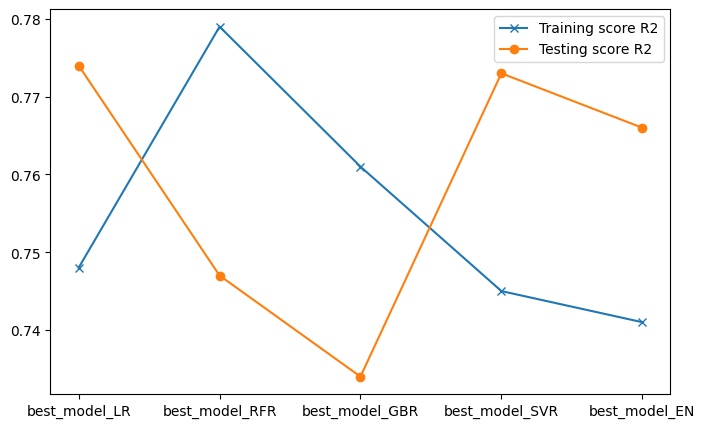

In [318]:
# visualisation des scores des différents modèles
plt.figure(figsize=(8,5))

models        = ['best_model_LR', 'best_model_RFR', 'best_model_GBR', 'best_model_SVR', 'best_model_EN']
train_score  = [best_model_LR.score(X_train, y_train).round(3), best_model_RFR.score(X_train, y_train).round(3), best_model_GBR.score(X_train, y_train).round(3), best_model_SVR.score(X_train, y_train).round(3), best_model_EN.score(X_train, y_train).round(3)]
test_score    = [best_model_LR.score(X_test, y_test).round(3), best_model_RFR.score(X_test, y_test).round(3), best_model_GBR.score(X_test, y_test).round(3), best_model_SVR.score(X_test, y_test).round(3), best_model_EN.score(X_test, y_test).round(3)]

plt.plot(models, train_score, label='Training score R2', marker='x')
plt.plot(models, test_score, label='Testing score R2', marker='o')

plt.legend()
plt.show()

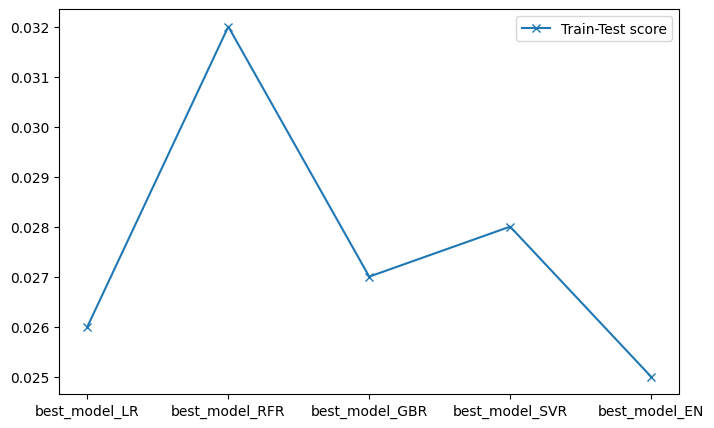

In [319]:
# visualisation des différences de scores des différents modèles
plt.figure(figsize=(8,5))

models        = ['best_model_LR', 'best_model_RFR', 'best_model_GBR', 'best_model_SVR', 'best_model_EN']
diff_score = [np.abs(a - b) for a, b in zip(train_score, test_score)]

plt.plot(models, diff_score, label='Train-Test score', marker='x')

plt.legend()
plt.show()

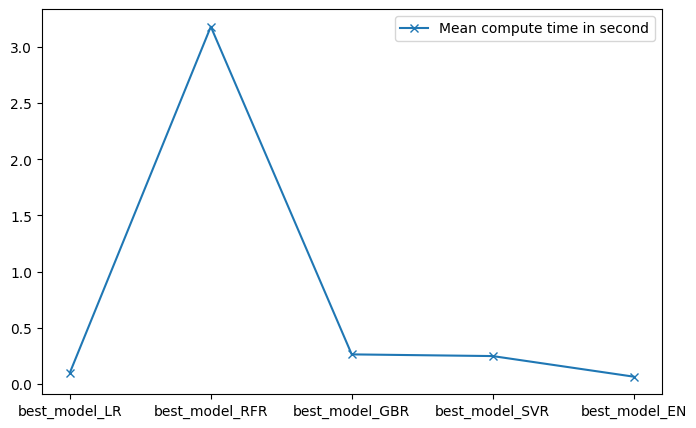

In [320]:
# visualisation du temps de computage
plt.figure(figsize=(8,5))
mean_process_time = [mean_time_LR, mean_time_RFR, mean_time_GBR, mean_time_SVR, mean_time_EN]
plt.plot(models, mean_process_time, label='Mean compute time in second', marker='x')

plt.legend()
plt.show()

Si on s'appuie sur les scores de test, les modèles intéressants sont la régression linéaire, l'elastic net et le support vector regression.

Les résultats étant assez similaires, j'ai choisi de prendre le modèle le plus simple c'est à dire la régression linéaire.

**Récupération et réentrainement du modèle de régression linéaire**

In [321]:
# Réentrainement
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

param_grid = {
    'regressor__fit_intercept' : [False, True]
    }

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2') #1476*0.80/5 = 236 données par pli pour cv=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR = gs.best_estimator_
print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}') #moyenne des scores sur la validation croisée
print('----------------')

# model scoring
best_score_LR_test = best_model_LR.score(X_train, y_train).round(3)
best_score_LR_train = best_model_LR.score(X_test, y_test).round(3)
print(f'Score sur le train : {best_score_LR_train}')
print(f'Score sur le test : {best_score_LR_test}')
print(f'diff = {(best_score_LR_test-best_score_LR_train).round(3)}')
mean_time_LR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__fit_intercept': True}
Moyenne des scores: 0.736
----------------
Score sur le train : 0.774
Score sur le test : 0.748
diff = -0.026


In [322]:
# Récupération des hyperparamètres
print('liste des parameters de la régression lineaire :')
print(f'intercept: {best_model_LR[1].intercept_.round(2)}')

print(best_model_LR[1].get_params())

liste des parameters de la régression lineaire :
intercept: 3.98
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


In [323]:
# Récupération des coefficients
feature_names = best_model_LR.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_model_LR.named_steps['regressor'].coef_.round(2)
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df_sorted = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
coef_df_sorted

,Feature,Coefficient
15,norma__PropertyGFATotal,0.92
21,norma__RatioElectricity,-0.84
9,encoder_nominal__LargestPropertyUseType_Non-Refrigerated Warehouse,-0.56
16,norma__ENERGYSTARScore,-0.28
12,encoder_nominal__LargestPropertyUseType_Retail Store,0.21
11,encoder_nominal__LargestPropertyUseType_Other,0.17
3,encoder_nominal__Neighborhood_LAKE UNION,0.14
2,encoder_nominal__Neighborhood_GREATER DUWAMISH,-0.13
20,norma__RatioSteamUse,0.13
18,norma__BuildingAge,-0.12


Les variables qui ont le plus d'impact sur le modèle sont dans l'ordre:
PropertyGFATotal (0.92), RatioElectricity (-0.84),
LargestPropertyUseType_Non-Refrigerated Warehouse	(-0.56) et
ENERGYSTARScore	(-0.28).

- Plus la superficie est grande, plus les besoins énergétiques sont importants, ce qui se traduit par des émissions de CO2 plus élevées.
- L'électricité est souvent plus efficace que d'autres sources d'énergie fossile, ce qui peut également contribuer à des émissions de CO2 plus faibles.
-  Les entrepôts non réfrigérés ont généralement des besoins énergétiques plus faibles par rapport à d'autres types de bâtiments comme les bureaux, les entrepôts réfrigérés. Ils nécessitent moins de chauffage, de climatisation et d'éclairage, ce qui se traduit par des émissions de CO2 plus faibles. De plus, ces bâtiments peuvent avoir des horaires d'utilisation plus limités, réduisant encore leur consommation d'énergie.
- Un score ENERGY STAR plus élevé signifie que le bâtiment est plus efficace sur le plan énergétique, ce qui se traduit par une consommation d'énergie plus faible et, par conséquent, des émissions de CO2 plus faibles.

Le score ENERGY STAR est chronophage et coûteux en terme de ressources. Voyons l'efficacité de notre modèle de régression linéaire sans cette variable.



# **V. Estimer l'effet de la variable ENERGYSTARScore**

In [293]:
# préparation des données
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'PropertyGFAParking']

CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'SiteEnergyUse(kBtu)' and f != 'ENERGYSTARScore']
print(CAT_FEATURES)

['Neighborhood', 'LargestPropertyUseType']


In [294]:
df2 = df.copy()
df2.drop(columns=['ENERGYSTARScore'], inplace=True)

y = df2.pop(TARGET)
X = df2
y = np.log(y + 1)

In [295]:
# entrainement
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

param_grid = {}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2') #1476*0.80/5 = 236 données par pli pour cv=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR_minus_star = gs.best_estimator_

print(f'Moyenne des scores: {gs.best_score_.round(3)}') #moyenne des scores sur la validation croisée
print('----------------')

# model scoring
best_score_LR_train_minus_star = best_model_LR_minus_star.score(X_train, y_train).round(3)
best_score_LR_test_minus_star  = best_model_LR_minus_star.score(X_test, y_test).round(3)
print(f'Score sur le train : {best_score_LR_train_minus_star}')
print(f'Score sur le test : {best_score_LR_test_minus_star}')
print(f'diff = {(best_score_LR_train_minus_star-best_score_LR_test_minus_star).round(3)}')
mean_time_LR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Moyenne des scores: 0.704
----------------
Score sur le train : 0.715
Score sur le test : 0.737
diff = -0.022


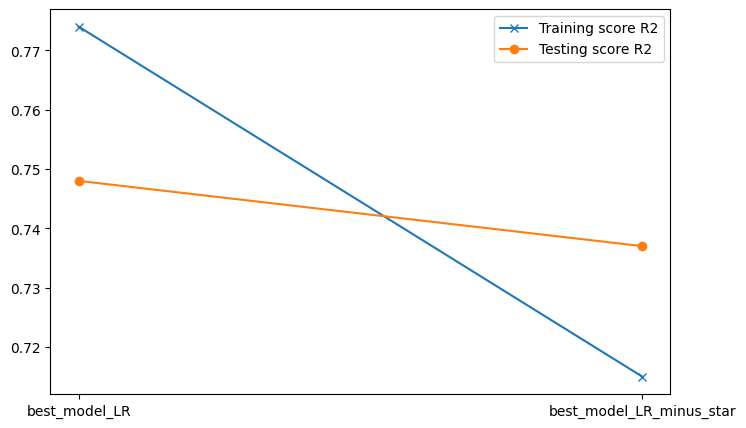

différence sur le test: 0.01100000000000001


In [296]:
# comparaison
plt.figure(figsize=(8,5))

models        = ['best_model_LR', 'best_model_LR_minus_star']
train_score   = [best_score_LR_train, best_score_LR_train_minus_star]
test_score    = [best_score_LR_test, best_score_LR_test_minus_star]

plt.plot(models, train_score, label='Training score R2', marker='x')
plt.plot(models, test_score, label='Testing score R2', marker='o')

plt.legend()
plt.show()
diff_score_test = (best_score_LR_test-best_score_LR_test_minus_star).round(3)
print(f'différence sur le test: {diff_score_test}')

Sans la variable ENERGYSTARScore, la perte de précision est de l'ordre de 0.02.

In [297]:
#Voir combien représente une erreur de 0.01
y = np.exp(y - 1)
print(f'moyenne des émissions de carbones: {y.mean()} tonne de dioxyde de carbone.')
print(f'erreur sur la moyenne du jeu de données de {diff_score_test} sur la prédiction : {y.mean()*diff_score[1]} tonne de dioxyde de carbone.')

moyenne des émissions de carbones: 62.64551957929578 tonne de dioxyde de carbone.
erreur sur la moyenne du jeu de données de 0.01100000000000001 sur la prédiction : 1.3782014307445083 tonne de dioxyde de carbone.


Pour savoir si l'on conserve ou non la variable, il faut prendre en compte les ressources nécessaires pour la calculer et également le degré de précision que l'on souhaite avoir.

L'erreur ici est d'environ 1% ce qui est acceptable dans notre contexte.

#**Conclusion**

Le modèle choisi est le modèle de régression linéaire dont la valeur de R² est de 0.77 sur le score du test ce qui est un bon score.

Il est envisageable de retirer la variable ENERGYSTARScore 0.73